<a href="https://colab.research.google.com/github/fahmiajik12/Fahmiajik.github.io/blob/master/PCD_Xray_Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Persiapan Data

Dataset yang digunakan adalah dataset yang tersedia pada kaggle dengan link sebagai berikut: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia


In [ ]:
#instalasi kaggel
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fahmiajik","key":"1c83629dcc46dd351c1ba6866bdbbc62"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#mengambil dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:02<00:00, 45.3MB/s]
100% 2.29G/2.29G [01:02<00:00, 39.2MB/s]


In [ ]:
#mengekstrak dataset pada /content/
!unzip chest-xray-pneumonia.zip
!rm chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
import os
import cv2
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
from PIL import Image
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import add
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

np.random.seed(777)
tf.random.set_seed(777)

In [ ]:
BATCH_SIZE = 32
IMG_HEIGHT = 240
IMG_WIDTH = 240
ALPHA = 1e-4

# Load Data

Kernel ini menggunakan dataset Chest X-Ray Images (Pneumonia), yang disusun menjadi 3 folder (train, test, val) dan berisi subfolder untuk setiap kategori gambar (Pneumonia / Normal). Ada 5.863 gambar X-Ray (JPEG) dan 2 kategori (Pneumonia / Normal).

Untuk analisis gambar Chest X-Ray, semua radiografi dada pada awalnya diskrining untuk kontrol kualitas dengan menghapus semua pindaian berkualitas rendah atau tidak terbaca. 

In [ ]:
data_dir = '/content/chest_xray'

In [ ]:
labels = ['NORMAL','PNEUMONIA']
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE) 
                resized_arr = cv2.resize(img_arr, (IMG_WIDTH, IMG_HEIGHT))
                data.append([resized_arr, class_num])
            except Exception as e:
                pass

    return np.array(data)

kemudian mendefinisikan fungsi untuk mengembalikan np.array dengan semua gambar yang terletak di direktori tertentu dan menggunakannya untuk memuat data training, validation dan test data

In [ ]:
train = get_data('/content/chest_xray/train/')
test = get_data('/content/chest_xray/test/')
val = get_data('/content/chest_xray/val/')

<ipython-input-9-d819901f3259>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


kemudian untuk melihat berapa banyak gambar yang dimiliki dari setiap class di training set. Selain itu, mari kita lihat bagaimana gambar didistribusikan diantara training, validation dan test data

In [ ]:
print(f"{[y for _, y in train].count(0)} NORMAL IMAGES IN TRAINING SET")
print(f"{[y for _, y in train].count(1)} PNEUMONIA IMAGES IN TRAINING SET")

1341 NORMAL IMAGES IN TRAINING SET
3875 PNEUMONIA IMAGES IN TRAINING SET


In [ ]:
print(f'Images in TRAINING SET: {train.shape[0]}')
print(f'Images in VALIDATION SET: {val.shape[0]}')
print(f'Images in TEST SET: {test.shape[0]}')

Images in TRAINING SET: 5216
Images in VALIDATION SET: 16
Images in TEST SET: 624


Seperti yang dapat dilihat pada output dari dua cell sebelumnya, terdapat masalah data yang tidak seimbang dan dengan proporsi yang agak aneh antara training set dan validation set.

masalah tersebut akan coba diatasi dalam tahap pemrosesan data, untuk saat ini yang dilakukan hanya akan menggabungkan dataset train dan val kemudian melakukan pemisahan data lagi.

In [ ]:
train = np.append(train, val, axis=0)
train, val = train_test_split(train, test_size=.20, random_state=777)

Untuk mengakhiri bagian ini, akan ditampilkan beberapa contoh dalam dataset yang dimiliki.

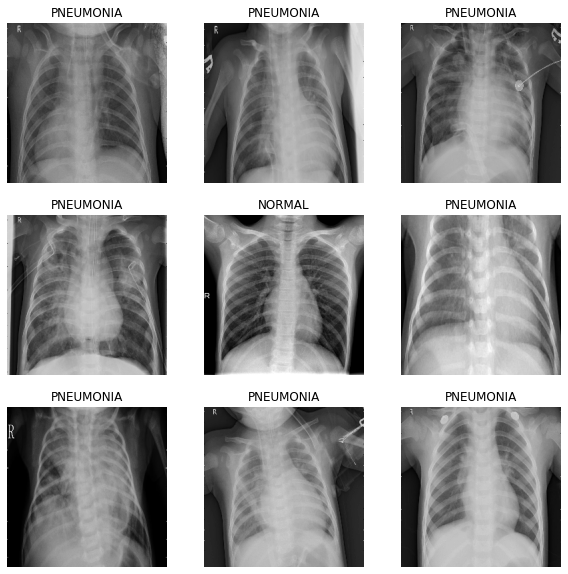

In [ ]:
plt.figure(figsize=(10, 10))
for k, i in np.ndenumerate(np.random.randint(train.shape[0], size=9)):
    ax = plt.subplot(3, 3, k[0] + 1)
    plt.imshow(train[i][0], cmap='gray')
    plt.title(labels[train[i][1]])
    plt.axis("off")

# Data Processing 

pada tahap awal ini akan membuat dan menggunakan fungsi yang disebut prepared_data () yang akan menormalkan gambar (membagi setiap piksel dengan 255) dan me-reshape array menjadi sesuai bentuk. Setelah itu, fungsi akan mengembalikan array x dan y secara terpisah dari set yang digunakan.

In [ ]:
def prepare_data(data):
    x = []
    y = []
    
    for feature, label in data:
        x.append(feature)
        y.append(label)
        
    x = (np.array(x) / 255).reshape(-1,IMG_WIDTH, IMG_HEIGHT, 1)
    y = np.array(y)
        
    return x, y

x_train, y_train = prepare_data(train)
x_val, y_val = prepare_data(val)
x_test, y_test = prepare_data(test)

Untuk mencari performa terbaik dari model yang dilakukan, penting untuk menambah jumlah sampel dalam dataset dan untuk itu perlu melakukan proses data augumentasi.
kemudian juga ditampilkan hasil dari data augmentasi yang dilakukan

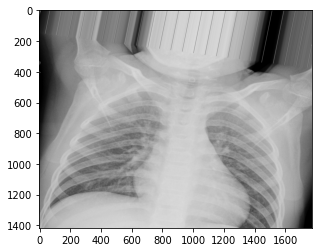

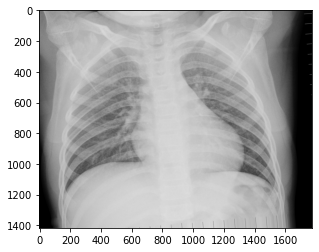

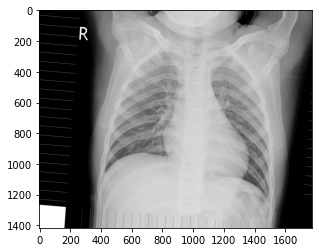

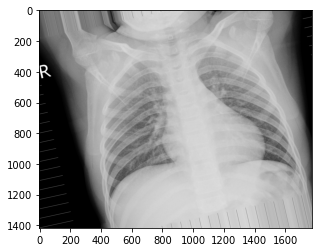

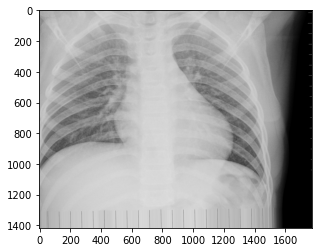

In [ ]:
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range = 20, 
    zoom_range = 0.2, 
    width_shift_range=0.15,  
    height_shift_range=0.15,
    horizontal_flip = False,  
    vertical_flip=False)


datagen.fit(x_train)

# pick an image to transform
image_path = '/content/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg'
img = image.load_img(image_path)


img=image.img_to_array(img)
img=img.reshape((1,) + img.shape)

i = 0

for batch in datagen.flow(img, save_prefix='test', save_format='jpeg'):  # this loops runs forever until we break, saving images to current directory with specified prefix
    plt.figure(i)
    plot = plt.imshow(image.img_to_array(batch[0]).astype(np.uint8))
    i += 1
    if i > 4: 
        break

plt.show()

Nah, untuk menyelesaikan masalah ketidak seimbangan data yang disebutkan sebelumnya. Ada beberapa kemungkinan pendekatan untuk diambil untuk memberikan weight (bobot) yang berbeda tiap kelas.

weight ini akan digunakan di pada proses lanjutan sebagai parameter yang sesuai dengan model, dan dijelaskan dalam dokumentasi resmi Keras, fungsi compute_class_weight() dapat berguna untuk memberi tahu model agar "lebih memperhatikan" sampel dari under-represented class.


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)

class_weights = {0: class_weights[0], 1: class_weights[1]}

print(class_weights)

{0: 1.9339186691312384, 1: 0.6743474057363842}


# Membuat Model

tahap pembuatan model.
pada kesempatan kali ini akan menggunakan CNN yang hampir sama dengan yang ada dari paper **Efficient Deep Network Architectures for Fast Chest X-Ray Tuberculosis Screening and Visualization**. Model yang disajikan memiliki arsitektur berikut: 

dikatakan hampir sama karena tidak sepenuhnya sama karena model kali ini menggunakan aktivasi sigmoid (pada paper menggunakan aktivasi Softmax) di lapisan terakhir dari model. Namun secara umum tidak mengubah apa pun, karena fungsi Softmax adalah generalisasi fungsi sigmoid tetapi berlaku untuk masalah multilabel.
 

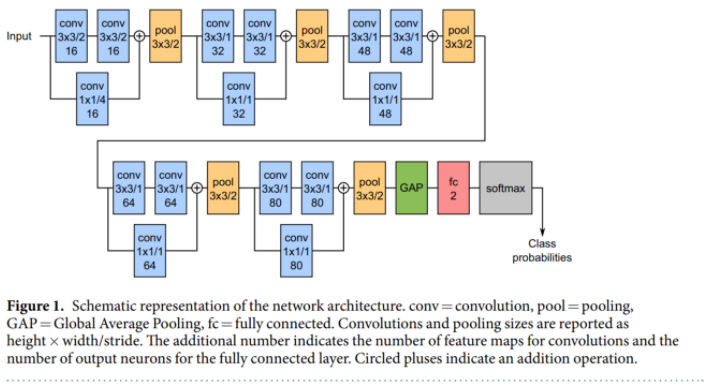

In [ ]:
def block(inputs, filters, stride):
    conv_0 = layers.Conv2D(filters=filters, kernel_size=(3, 3), strides=(stride, stride), padding='same', activation='relu')(inputs)
    conv_1 = layers.Conv2D(filters=filters, kernel_size=(3, 3), strides=(stride, stride), padding='same', activation='relu')(conv_0)
    
    skip = layers.Conv2D(input_shape=input_size, filters=filters, kernel_size=(1, 1), strides=(stride**2, stride**2), padding='same', activation='relu')(inputs)
    
    pool = layers.MaxPool2D(pool_size=(3, 3), strides=(2,2), padding='same')(add([conv_1, skip]))
    
    return pool

In [ ]:
input_size = (IMG_HEIGHT, IMG_WIDTH, 1)

inputs = tf.keras.Input(shape=input_size, name='input')

y_0 = block(inputs, 16, 2)
y_1 = block(y_0, 32, 1)
y_2 = block(y_1, 48, 1)
y_3 = block(y_2, 64, 1)
y_4 = block(y_3, 80, 1)

gap = layers.GlobalMaxPooling2D()(y_4)
dense = layers.Dense(2, activation='relu')(gap)

outputs = layers.Dense(1, activation='sigmoid')(dense)

In [ ]:
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="pneumonia_model")
model.summary()

Model: "pneumonia_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 240, 240, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 120, 120, 16  160         ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 60, 60, 16)   2320        ['conv2d[0][0]']                 
                                                                                    

# Visualisasi Layer Filter

In [ ]:
# summarize filter shapes
for layer in model.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
  # get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

conv2d (3, 3, 1, 16)
conv2d_1 (3, 3, 16, 16)
conv2d_2 (1, 1, 1, 16)
conv2d_3 (3, 3, 16, 32)
conv2d_4 (3, 3, 32, 32)
conv2d_5 (1, 1, 16, 32)
conv2d_6 (3, 3, 32, 48)
conv2d_7 (3, 3, 48, 48)
conv2d_8 (1, 1, 32, 48)
conv2d_9 (3, 3, 48, 64)
conv2d_10 (3, 3, 64, 64)
conv2d_11 (1, 1, 48, 64)
conv2d_12 (3, 3, 64, 80)
conv2d_13 (3, 3, 80, 80)
conv2d_14 (1, 1, 64, 80)


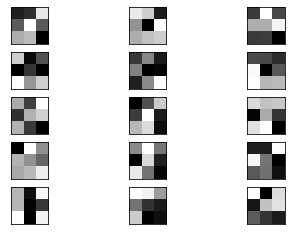

In [ ]:
filters, biases = model.layers[2].get_weights()
# Normalisasi nilai filter ke 0-1 untuk dapat divisualisasikan
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot beberapa filter pertama
n_filters, ix = 5, 1
for i in range(n_filters):
	# mendapatkan filter
	f = filters[:, :, :, i]
	# plot channel secara separately
	for j in range(3):
		# specify subplot
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel dalam grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# Menampilkan gambar
plt.show()

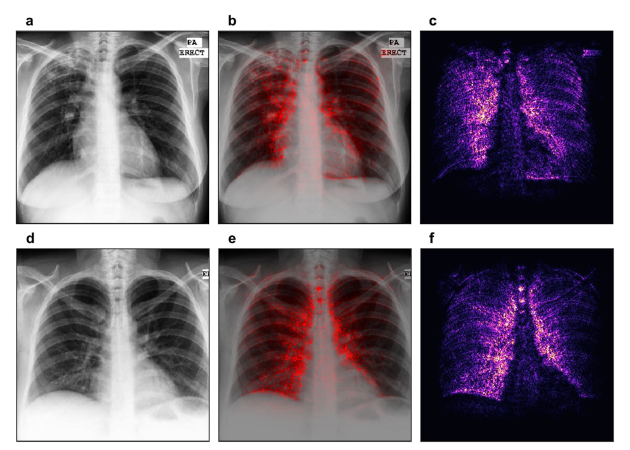

Peta saliency dengan overlay untuk dua kasus yang diklasifikasikan dengan benar. Panel (a) dan (d) menunjukkan gambar dada pasien, panel (c) dan (f) menunjukkan peta saliency, sedangkan panel (b) dan (e) menunjukkan peta saliency yang dihamparkan pada gambar dada untuk perbandingan. Baris pertama menunjukkan pasien tuberkulosis dengan skor output 0,98 (maksimal 1). Baris kedua menunjukkan pasien sehat dengan skor 0,00 (minimal 0). Kedua skor menunjukkan keyakinan tinggi dalam prediksi


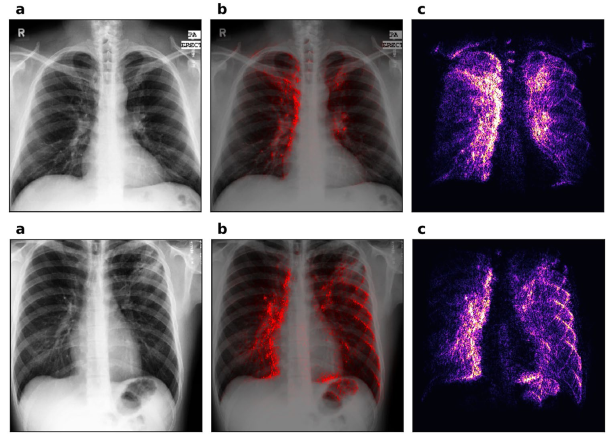

Peta saliency dengan overlay untuk dua pasien yang salah klasifikasi. Panel (a) dan (d) menunjukkan gambar dada pasien, panel (c) dan (f) menunjukkan peta saliency, sedangkan panel (b) dan (e) menunjukkan peta saliency yang dihamparkan pada gambar dada untuk perbandingan. Baris pertama menunjukkan pasien sehat diklasifikasikan dengan skor output 0,98 (maksimal 1). Baris kedua menunjukkan pasien tuberkulosis dengan skor output 0,04 (minimal 0). Kedua skor menunjukkan kesalahan klasifikasi yang serius

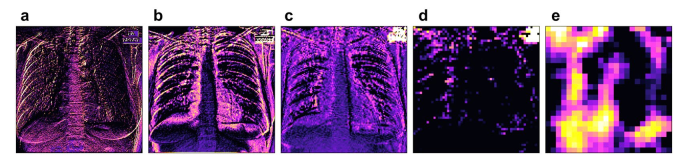

Peta aktivasi kelas gradien (grad-CAMs) untuk lapisan berbeda dari pasien yang sama. Panel (a) menunjukkan layer 1, (b) layer 4, (c) layer 7, (d) layer 10 dan (e) layer 13. Skala dari setiap panel tidak bergantung satu sama lain. Pasien juga ditunjukkan pada baris pertama Gambar 3 (positif benar). Peta aktivasi dihitung untuk kelas positif dan ditampilkan untuk lapisan terakhir dari setiap blok konvolusional (misalnya yang tepat sebelum penggabungan). Peta aktivasi dari lapisan yang lebih tinggi menunjukkan fitur tingkat yang lebih tinggi, yang seharusnya spesifik untuk tuberkulosis. 

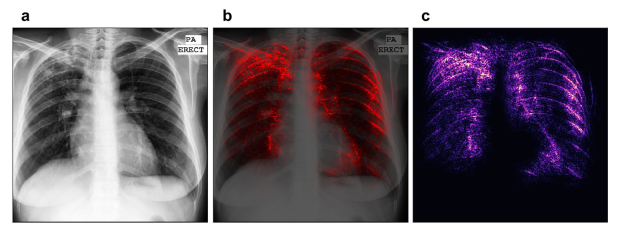

Peta saliency jaringan dilatih pada kumpulan data gabungan, menggunakan sekitar 660 pasien untuk pelatihan. Panel (a) menunjukkan gambar dada pasien, panel (c) menunjukkan peta saliency, sedangkan panel (b) menunjukkan peta saliency yang dihamparkan pada gambar dada untuk perbandingan. Gambar ini harus dibandingkan dengan baris pertama dari Gambar., Yang menunjukkan peta saliency yang diprediksi untuk pasien yang sama, tetapi dengan jaringan yang dilatih hanya pada dataset Montgomery. Kemampuan lokalisasi peta saliency ini meningkat secara drastis. Gambar tampak tidak terlalu berisik di wilayah yang tidak penting dan lebih intens di area yang benar-benar terdapat tuberkulosis. 

# Melatih Model

dalam melatih model dilakukan pendefinisian beberapa callback seperti ReduceLROnPlateau dan EarlyStopping yang akan membantu kita mendapatkan pelatihan yang lebih cepat.
Seperti yang didefinisikan di referensi Keras API, megurangi learning rate saat metrik berhenti meningkat, dan itu berguna karena model sering kali mendapatkan keuntungan dari pengurangan kecepatan pemelajaran sebesar faktor 2-10 setelah pembelajaran mandek. Callback ini memantau kuantitas dan jika tidak ada peningkatan yang terlihat untuk jumlah 'patience' epoch, kecepatan pembelajaran akan berkurang. Selain itu, penghentian awal adalah bentuk regularisasi dan dengan demikian akan membantu kami mencegah overfitting.


In [ ]:
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.7, min_delta=ALPHA, patience=7, verbose=1)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)

In [ ]:
CALLBACKS = [lr_reduce, early_stopping_cb]

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get('accuracy') > 0.99):
      print('\nAkurasi mencapai 99%')
      self.model.stop_training = True

callbacks = myCallback()
     

Untuk metrik, digunakan accuracy, precision, dan recall. Pilihan ini dibuat karena:

1. Accuracy, meskipun merupakan metrik yang paling banyak digunakan, memberikan informasi yang cukup tentang seberapa baik performa model, karena memiliki masalah data yang tidak seimbang.
2. Precision memberikan rasio tp / (tp + fp) atau secara intuitif menentukan kemampuan pengklasifikasi untuk tidak memberi label positif pada sampel yang negatif.
3. Recall memberikan rasio tp / (tp + fn) atau secara intuitif kemampuan pengklasifikasi untuk menemukan semua sampel positif.


In [ ]:
METRICS = ['accuracy',
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall')]

Optimizer yang digunakan adalah Adam, karena optimizer ini menggabungkan properti terbaik dari algoritma AdaGrad dan RMSProp untuk menyediakan algoritma pengoptimalan yang dapat menangani gradien renggang pada noisy. Untuk loss, hanya dua label yang memungkinkan, maka akan menggunakan binary crossentropy.

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=ALPHA),
    loss='binary_crossentropy', 
    metrics=METRICS
)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Menampilkan visualisasi menggunakan Tensorboard pada setiap matrik

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
import os
import datetime

In [ ]:
filepath="weight_pneunomia_best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only= True, mode='max')
callbacks_list = [checkpoint]

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks_list.append(TensorBoard(logdir,histogram_freq=1))


kemudian menyesuaikan model. Penting untuk diingat di sini untuk menggunakan weight untuk class yang yang sudah dihitung sebelumnya

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = BATCH_SIZE),
                    steps_per_epoch=x_train.shape[0]/BATCH_SIZE, 
                    validation_data = (x_val, y_val),
                    validation_steps=x_val.shape[0]/BATCH_SIZE,
                    callbacks = callbacks_list,
                    class_weight = class_weights,
                    epochs = 30)

Epoch 1/30
131/130 [==============================] - ETA: 0s - loss: 0.6816 - accuracy: 0.7541 - precision: 0.7821 - recall: 0.9265
Epoch 1: val_accuracy improved from -inf to 0.77746, saving model to weight_pneunomia_best.h5
130/130 [==============================] - 27s 141ms/step - loss: 0.6816 - accuracy: 0.7541 - precision: 0.7821 - recall: 0.9265 - val_loss: 0.6139 - val_accuracy: 0.7775 - val_precision: 0.7777 - val_recall: 0.9821
Epoch 2/30
131/130 [==============================] - ETA: 0s - loss: 0.5840 - accuracy: 0.8325 - precision: 0.8568 - recall: 0.9294
Epoch 2: val_accuracy improved from 0.77746 to 0.88921, saving model to weight_pneunomia_best.h5
130/130 [==============================] - 18s 135ms/step - loss: 0.5840 - accuracy: 0.8325 - precision: 0.8568 - recall: 0.9294 - val_loss: 0.4203 - val_accuracy: 0.8892 - val_precision: 0.9689 - val_recall: 0.8795
Epoch 3/30
131/130 [==============================] - ETA: 0s - loss: 0.5000 - accuracy: 0.8796 - precision: 0.

visualisasi menggunakan tensorboard
Salah satu hal terpenting yang harus dilakukan terkait pelatihan model adalah memvisualisasikan evolusi performanya. Dalam pengertian ini, akan memplot nilai akurasi, presisi, recall, dan AUC setiap epoch menggunakan tensorboard.

In [ ]:
%load_ext tensorboard

%tensorboard --logdir logs

<IPython.core.display.Javascript object>

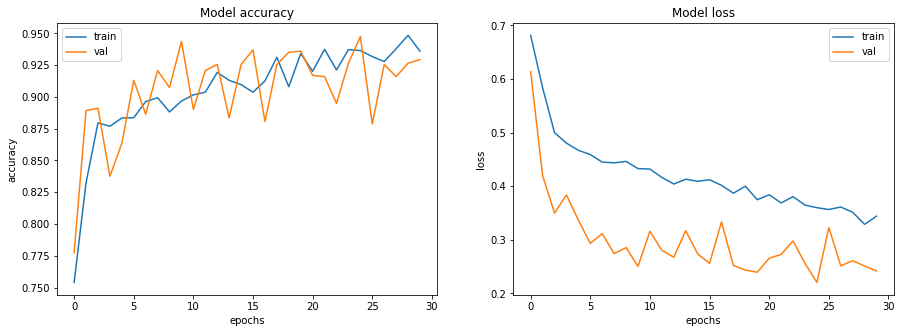

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# Evaluasi Model

mencoba menghasilkan prediksi dari data yang belum pernah dilihat sebelumnya dan memeriksa performa model yang dimiliki.

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 12ms/step - loss: 0.3975 - accuracy: 0.8974 - precision: 0.8976 - recall: 0.9436
Loss of the model is -  0.3974605202674866
20/20 [==============================] - 0s 11ms/step - loss: 0.3975 - accuracy: 0.8974 - precision: 0.8976 - recall: 0.9436
Accuracy of the model is -  89.74359035491943 %


Dengan nilai akurasi, presisi, dan f1-score ini, jelas bahwa model yang digunakan dalam kernel ini menampilkan dirinya sebagai arsitektur yang solid dan sangat efisien untuk masalah yang dimaksud.

In [ ]:
predictions = model.predict(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[predictions >= 0.5] = 1
predictions[predictions < 0.5] = 0

20/20 [==============================] - 0s 6ms/step


In [ ]:
print(classification_report(y_test, predictions, target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))

                     precision    recall  f1-score   support

   Normal (Class 0)       0.90      0.82      0.86       234
Pneumonia (Class 1)       0.90      0.94      0.92       390

           accuracy                           0.90       624
          macro avg       0.90      0.88      0.89       624
       weighted avg       0.90      0.90      0.90       624



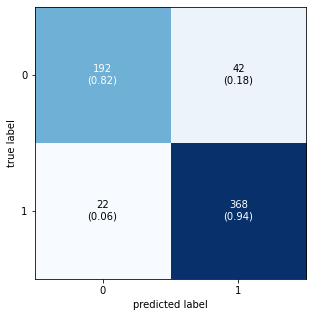

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_test,predictions)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

fig, ax = plot_confusion_matrix(conf_mat=cm , show_normed=True, figsize=(5, 5))
plt.show()

Seperti yang dapat dilihat dalam report klassifikasi dan pada confusion matrix, model model yang dihasilkan bekerja dengan baik, baik dalam klasifikasi kasus positif pneumonia maupun dalam klasifikasi kasus negatif.

# Uji Gambar

33/33 [==============================] - 0s 7ms/step
Class : 0


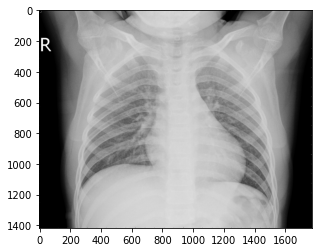

In [ ]:
testing_path="/content/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg"
img= image.load_img(testing_path)
plt.imshow(img)

x=image.img_to_array(img)
x=x.reshape((1,) + x.shape)

val=model.predict(x_val)
result = np.argmax(val[0]).tolist()
print('Class : '+str(result))

# Menyimpan model

In [ ]:
import keras
model.save("project_pcd_pneunomia.h5")  # we can save the model and reload it at anytime in the future
new_model = keras.models.load_model('project_pcd_pneunomia.h5')

# Kesimpulan

Pengujian deep learning dengan menggunakan arsitektur Convolutional Neural Networks (CNN) untuk mengklasifikasikan gambar *Chest X-Ray* pada kelompok normal atau terdapat penyakit pneunomia didapat hasil yang cukup baik. Namun masih banyak hal yang dapat dikembangkan dengan menyempurnakan parameter atau yang serupa, lebih mendalami AI untuk data yang tidak seimbang maupun cara mengevaluasi model dimiliki.